# Cassava Leaf Disease Classification
- https://www.kaggle.com/c/cassava-leaf-disease-classification/overview
    
### Background
- In Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions.  
but viral diseases are major sources of poor yields.

### Competition
- dataset of 21,367 labeled images collected during a regular survey in Uganda. 
- **5 classes: 4 diseases and 1 healthy**
- Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts  
at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. 
- classify each cassava image into four disease categories or a fifth category indicating a healthy leaf.

## 0. Import Packages

In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import json
import cv2
import sys
import tarfile
import glob
from six.moves import urllib
import random
import shutil
import imageio
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB3
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input

import numpy as np
import pandas as pd
from matplotlib import pyplot
from numpy import expand_dims
import matplotlib.pyplot as plt

## 1. Explore and Visualize dataset

In [13]:
BASE_DIR = os.getcwd()
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [14]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"Number of train images: {len(input_files)}")

Number of train images: 21397


In [15]:
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:300]:
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1

print(img_shapes)

{(600, 800, 3): 300}


In [16]:
df_train = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
df_train["class_name"] = df_train["label"].map(map_classes)
df_train

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)
...,...,...,...
21392,999068805.jpg,3,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,3,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,1,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,4,Healthy


In [17]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 20))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(1, 4, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

In [18]:
tmp_df0 = df_train[df_train["label"] == 0]
print(f"Total train images for class 0: {tmp_df0.shape[0]}")
tmp_df1 = df_train[df_train["label"] == 1]
print(f"Total train images for class 1: {tmp_df1.shape[0]}")
tmp_df2 = df_train[df_train["label"] == 2]
print(f"Total train images for class 2: {tmp_df2.shape[0]}")
tmp_df3 = df_train[df_train["label"] == 3]
print(f"Total train images for class 3: {tmp_df3.shape[0]}")
tmp_df4 = df_train[df_train["label"] == 4]
print(f"Total train images for class 4: {tmp_df4.shape[0]}")

Total train images for class 0: 1087
Total train images for class 1: 2189
Total train images for class 2: 2386
Total train images for class 3: 13158
Total train images for class 4: 2577


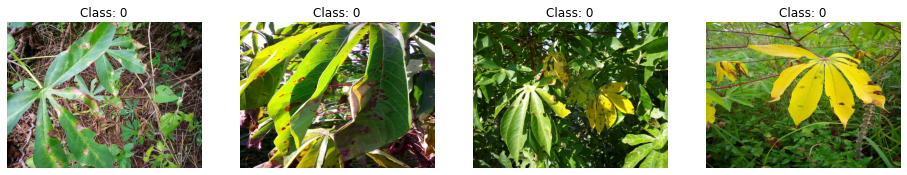

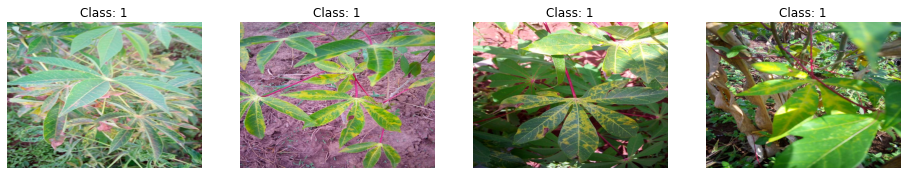

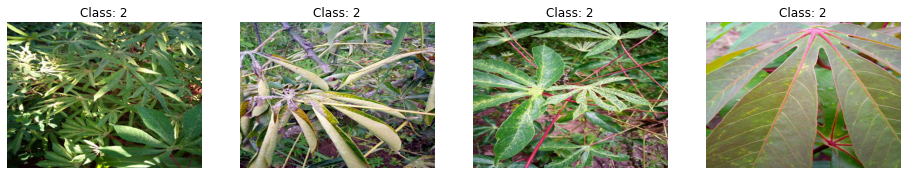

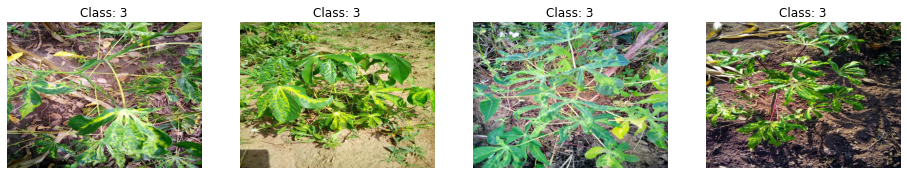

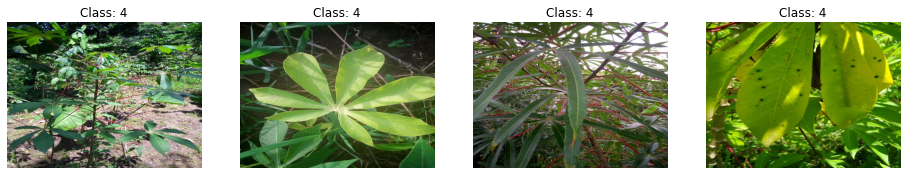

In [19]:
# visualization
for i in range(5):
    tmp_df = globals()['tmp_df{}'.format(i)].sample(4)
    image_ids = tmp_df["image_id"].values
    labels = tmp_df["label"].values

    visualize_batch(image_ids, labels)

## 2. Training - EfficientNet

In [20]:
train_labels = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

# parameters
batch_size = 32
steps_per_epoch = len(train_labels)*0.8 / batch_size
validation_steps = len(train_labels)*0.2 / batch_size
epochs = 1
target_size = 300
num_classes = 5

In [21]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
#                                    rescale = 1./255,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   shear_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (target_size, target_size),
                         batch_size = batch_size,
                         class_mode = "categorical")


validation_datagen = ImageDataGenerator(validation_split = 0.2) #rescale = 1./255)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (target_size, target_size),
                         batch_size = batch_size,
                         class_mode = "categorical")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [23]:
# download pretrained weights of EfficientNetB3
!wget https://storage.googleapis.com/keras-applications/efficientnetb3_notop.h5

In [24]:
model_weights_path = 'efficientnetb3_notop.h5'

In [25]:
b3model = EfficientNetB3(
            weights=None, 
            include_top=False, 
            input_shape=(target_size, target_size, 3),
            drop_connect_rate=0.4
        )
b3model.load_weights(model_weights_path)

In [26]:
model = Sequential()
model.add(b3model)
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(5, activation ='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               393472    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 11,179,316
Trainable params: 11,091,501
Non-trainable params: 87,815
_____________________________________

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
%%time
hist1 = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    verbose = 1)

## 3. Evaluation and Submission

In [29]:
def plot_accuracy_and_loss(hist):
    plt.figure(1, figsize= (15, 10))

    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.show()

In [ ]:
plot_accuracy_and_loss(hist1)

In [ ]:
# save model architecture
model_json = model.to_json()
open('EN1.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('EN1.h5', overwrite=True)

In [30]:
# Load trained model
from keras.models import model_from_json 

json_file = open("EN1.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
# model weight load 
loaded_model.load_weights("EN1.h5")
print("Loaded model from disk")

Loaded model from disk


In [33]:
pred_valid_y = loaded_model.predict(validation_generator,  verbose = True)
pred_valid_y_labels = np.argmax(pred_valid_y, axis=-1)
valid_labels = validation_generator.labels

134/134 [==============================] - 623s 5s/step


In [34]:
# from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(accuracy_score(valid_labels, pred_valid_y_labels ))

0.3993923813975228


In [ ]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"
df_sub = pd.read_csv(os.path.join(BASE_DIR, "sample_submission.csv"))
df_sub

In [ ]:
preds = []

for image_id in df_sub.image_id:
    image = Image.open(os.path.join(BASE_DIR,  "test_images", image_id))
    image = image.resize((target_size, target_size))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(loaded_model.predict(image)))

df_sub['label'] = preds
df_sub

In [ ]:
df_sub.to_csv('submission.csv', index = False)

# References  
[1] Cassava Leaf Disease - Exploratory Data Analysis, https://www.kaggle.com/ihelon/cassava-leaf-disease-exploratory-data-analysis  
[2] Cassava Leaf Disease: Best Keras CNN, https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-best-keras-cnn#Preparation-for-modeling